In [6]:
!pip install -q keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers, optimizers
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

def LoadDATA():
    filestr = os.getcwd()+'\\..\\Data\\MFCC_Data\\'
    Xtrain = filestr+'X_train.csv'  
    Ytrain = filestr+'Y_train.csv'  
    Xdev = filestr+'X_dev.csv'
    Ydev = filestr+'Y_dev.csv'  
    Xtest = filestr+'X_test.csv'
    Ytest = filestr+'Y_test.csv' 
    Xdemo = filestr+'X_demo.csv'
    Ydemo = filestr+'Y_demo.csv'
    
    x_train = pd.read_csv(Xtrain).values
    y_train = pd.read_csv(Ytrain).values  
    x_dev = pd.read_csv(Xdev).values
    y_dev = pd.read_csv(Ydev).values
    x_test = pd.read_csv(Xtest).values
    y_test = pd.read_csv(Ytest).values
    x_demo = pd.read_csv(Xdemo).values
    y_demo = pd.read_csv(Ydemo).values
  
    return x_train,x_test,x_dev,y_dev,y_train,y_test,x_demo,y_demo


def NNcode(x):
  
  Lparam     = int(x[0])
  bsizeparam = int(x[1])
  L2param    = int(x[2])/100
  Nparam     = int(x[3])
  
  #################### Hyperparameters ####################
  show_plots = 1                   # Bool, to show training plots
  L = Lparam                       # num layers in network
  bsize = bsizeparam               # minibatch size
  epochnum = 25                    # num epochs for optimization
  learning_rate = 0.001            # params for Adam
  learning_decay = 0.00001         # learning decay for Adam
  BN_mom = 0.99                    # momentum for batch norm
  L2 = np.ones(L)*L2param          # L2 lambda parameters for each layer
  N = np.append(np.ones(L-1)*Nparam,classes)   # num nodes/layer for each hidden layer
  #########################################################
  params = {}
  
  for l in range(1,L+1):
      params["L2_"+str(l)] = int(L2[l-1]*100)/100
      params["N"+str(l)] = int(N[l-1])

  ## NN Model (X->RELU->RELU->RELU->RELU->SOFTMAX)
  model = Sequential()
  model.add(Dense(params['N1'], activation='relu', input_dim=n_vec,use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=regularizers.l2(params["L2_1"]), bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None,name='fc1'))
  model.add(BatchNormalization(axis=1, momentum=BN_mom, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones',name='bn1'))
  for l in range(2,L-1):
      model.add(Dense(params['N'+str(l)], activation='relu',use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=regularizers.l2(params["L2_" + str(l)]), bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None,name='fc'+str(l)))
      model.add(BatchNormalization(axis=1, momentum=BN_mom, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones',name='bn'+str(l)))
  model.add(Dense(params['N'+str(L)], activation='softmax',use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=regularizers.l2(params["L2_" + str(L)]), bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None,name='fc'+str(L)))
  
  ## Compile and Train Model
  adam_opt = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=learning_decay, amsgrad=False)
  model.compile(loss='categorical_crossentropy',optimizer=adam_opt,metrics=['accuracy'])
  earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=10, verbose=0, mode='auto')
  history = model.fit(x_train, y_train,batch_size=bsize,epochs=epochnum,verbose=1,callbacks=[earlyStopping],validation_data=(x_dev, y_dev))
  
  ## Plots
  if show_plots == 1:
    #  "Accuracy"
    plt.plot(history.history['acc'],label="train")
    plt.plot(history.history['val_acc'],label="dev")
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'],label="train")
    plt.plot(history.history['val_loss'],label="dev")
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
  
    ## Test Model
    preds1 = model.evaluate(x_dev, y_dev, batch_size=bsize)
    preds2 = model.evaluate(x_test, y_test, batch_size=bsize)
    print ("Dev Accuracy = " + str(preds1[1]))
    print ("Test Accuracy = " + str(preds2[1]))
    print("with X = " + str(x.T))
  
    ## Predictions on Demo Set
    y_hat = model.predict(x_demo, batch_size=bsize)
  
  return preds2[1], y_hat, model

In [ ]:
# Grid Search over Hyperparameters
x_train,x_test,x_dev,y_dev,y_train,y_test,x_demo,y_demo = LoadDATA()
classes = y_train.shape[1]  # num speakers
n_vec =   x_train.shape[1]  # length of feature vector
m_train = x_train.shape[0]  # num training examples
m_test =  x_test.shape[0]   # num test examples

L_list = [2,5,7,10]
Bsize_list = [16,32,64,256]
L2_list = [0,.1,.3,.5,.7,1]
N_list = [10,100,390,500,1000]

len1 = len(L_list)
len2 = len(Bsize_list)
len3 = len(L2_list)
len4 = len(N_list)
len_total = len1*len2*len3*len4
count = 0
x = np.zeros((4,1))
params = np.zeros((len_total,4))
test_acc = np.zeros((len_total,1))

for i1 in range(len1):
    for i2 in range(len2):
        for i3 in range(len3):
            for i4 in range(len4):
                x[0] = L_list[i1]
                x[1] = Bsize_list[i2]
                x[2] = L2_list[i3]
                x[3] = N_list[i4]
                test_acc[count] = NNcode(x)
                params[count,:] = np.array([x[0],x[1],x[2],x[3]]).T        
                print('Run '+str(count+1)+' out of '+str(len_total))
                count = count+1
                
max_ind = np.argmax(test_acc)
print('Max Accuracy = '+str(test_acc[max_ind,0]*100)+'%')
print('with L = '+str(params[max_ind,0])+', Bsize = '+str(params[max_ind,1])+', L2 = '+str(params[max_ind,2])+', N = '+str(params[max_ind,3]))

## Plots
X1 = params[:,0]
X2 = params[:,1]
X3 = params[:,2]
X4 = params[:,3]
Y = test_acc

plt.plot(X1,Y,marker='o',linestyle='None',markersize=12)
plt.title('Test Accuracy vs NN Length')
plt.ylabel('Test Accuracy')
plt.xlabel('NN Length')
plt.show()

plt.plot(X2,Y,marker='o',linestyle='None',markersize=12)
plt.title('Test Accuracy vs Batch Size')
plt.ylabel('Test Accuracy')
plt.xlabel('Batch Size')
plt.show()

plt.plot(X3,Y,marker='o',linestyle='None',markersize=12)
plt.title('Test Accuracy vs L2 Lambda')
plt.ylabel('Test Accuracy')
plt.xlabel('Lambda')
plt.show()

plt.plot(X4,Y,marker='o',linestyle='None',markersize=12)
plt.title('Test Accuracy vs Nodes/Layer')
plt.ylabel('Test Accuracy')
plt.xlabel('Nodes/Layer')
plt.show()

Train on 290979 samples, validate on 7656 samples
Epoch 1/25
290979/290979 [==============================] - 136s 469us/step - loss: 0.8099 - acc: 0.7444 - val_loss: 0.3795 - val_acc: 0.8834
Epoch 2/25
290979/290979 [==============================] - 173s 596us/step - loss: 0.3495 - acc: 0.8856 - val_loss: 0.2277 - val_acc: 0.9244
Epoch 3/25
290979/290979 [==============================] - 153s 526us/step - loss: 0.2307 - acc: 0.9237 - val_loss: 0.1595 - val_acc: 0.9483
Epoch 4/25
290979/290979 [==============================] - 170s 583us/step - loss: 0.1706 - acc: 0.9434 - val_loss: 0.1255 - val_acc: 0.9591
Epoch 5/25
290979/290979 [==============================] - 186s 639us/step - loss: 0.1345 - acc: 0.9549 - val_loss: 0.1000 - val_acc: 0.9681
Epoch 6/25
290979/290979 [==============================] - 164s 564us/step - loss: 0.1094 - acc: 0.9634 - val_loss: 0.0953 - val_acc: 0.9687
Epoch 7/25
290979/290979 [==============================] - 143s 493us/step - loss: 0.0914 - acc: 

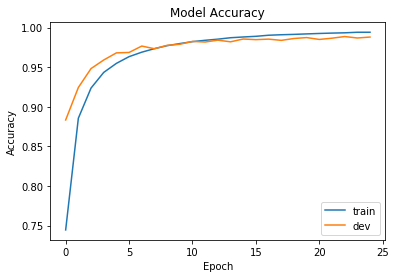

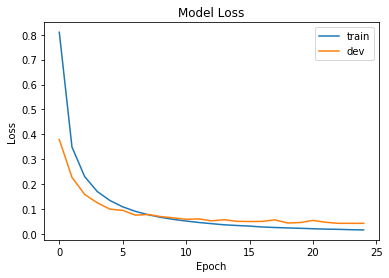

7656/7656 [==============================] - 1s 142us/step
Dev Accuracy = 0.9881138975966562
Test Accuracy = 0.9840647859134893
with X = [[  7.   64.    0.7 390. ]]


In [7]:
# Train and then Test on Demo Data
x_train,x_test,x_dev,y_dev,y_train,y_test,x_demo,y_demo = LoadDATA()
classes = y_train.shape[1]  # num speakers
n_vec =   x_train.shape[1]  # length of feature vector
m_train = x_train.shape[0]  # num training examples
m_test =  x_test.shape[0]   # num test examples

x = np.zeros((4,1))
x[0] = 7
x[1] = 64
x[2] = .7
x[3] = 390
test_acc, y_hat, model = NNcode(x)

model.save('NN_model.h5')
np.savetxt("DemoData.csv", y_hat, delimiter=",")